In [1]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
path = '/content/drive/My Drive/pictures'

In [6]:
import pathlib
data = pathlib.Path('/content/drive/My Drive/pictures/Great_Egret') 
count = len(list(data.glob('*.jpg')))
count

575

In [7]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(path)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.15)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/pictures
Found 926 images belonging to 16 classes.
Found 5299 images belonging to 16 classes.


In [8]:
train_datagen

In [9]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 16)
['American_Crow' 'American_Kestrel' 'American_Robin' 'Blue_Jay'
 'Carolina_Chickadee' 'Carolina_Wren' 'Common_Grackle' 'Eastern_Phoebe'
 'European_Starling' 'Great_Blue_Heron' 'Great_Egret' 'Northern_Flicker'
 'Northern_Mockingbird' 'Rock_Pigeon' 'Snowy_Egret' 'Tufted_Titmouse']


In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0

In [11]:
fit_model = model.fit(train_generator, validation_data = valid_generator,epochs=25)

Epoch 1/25
166/166 [==============================] - 1166s 7s/step - loss: 2.5640 - acc: 0.2416 - val_loss: 4.1711 - val_acc: 0.0724
Epoch 2/25
166/166 [==============================] - 65s 391ms/step - loss: 2.0397 - acc: 0.3525 - val_loss: 4.8461 - val_acc: 0.0724
Epoch 3/25
166/166 [==============================] - 65s 390ms/step - loss: 1.8022 - acc: 0.4191 - val_loss: 3.2201 - val_acc: 0.0821
Epoch 4/25
166/166 [==============================] - 67s 402ms/step - loss: 1.5895 - acc: 0.4824 - val_loss: 3.9214 - val_acc: 0.1274
Epoch 5/25
166/166 [==============================] - 63s 378ms/step - loss: 1.3982 - acc: 0.5458 - val_loss: 1.9763 - val_acc: 0.3963
Epoch 6/25
166/166 [==============================] - 65s 390ms/step - loss: 1.2264 - acc: 0.6054 - val_loss: 1.8727 - val_acc: 0.4438
Epoch 7/25
166/166 [==============================] - 65s 394ms/step - loss: 1.0773 - acc: 0.6531 - val_loss: 1.8176 - val_acc: 0.4762
Epoch 8/25
166/166 [==============================] - 65

In [12]:
# Evaluate the model using the validation data
model_loss, model_accuracy = model.evaluate(valid_generator)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

29/29 [==============================] - 9s 296ms/step - loss: 2.7259 - acc: 0.5194
Loss: 2.7258517742156982, Accuracy: 0.5194384455680847


In [13]:
def plot_history_metrics(fit_model):
    #plot accuracy = f(epoch)
    plt.plot(fit_model['accuracy'])
    plt.plot(fit_model['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'])
    plt.show()

    # # Plot loss = f(epoch)
    # plt.plot(fit_model.fit_model['loss'])
    # plt.plot(fit_model.fit_model['validation_data'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Valid'])
    # plt.show()

In [14]:
plt.show()

In [15]:
saved_model_path = "/content/drive/My Drive/bird_modelv4.h5" # or you can simply use 'my_mode.h5'
model.save(saved_model_path) #save your model 

# to reload your model 
model = keras.models.load_model(saved_model_path)

In [16]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [17]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 443ms/step
Prediction results for the first elements


,American_Crow,American_Kestrel,American_Robin,Blue_Jay,Carolina_Chickadee,Carolina_Wren,Common_Grackle,Eastern_Phoebe,European_Starling,Great_Blue_Heron,Great_Egret,Northern_Flicker,Northern_Mockingbird,Rock_Pigeon,Snowy_Egret,Tufted_Titmouse
0,5.177806e-07,1.648356e-07,1.141647e-07,6.485793e-06,4.098498e-07,1.215063e-05,4.038972e-09,7.273150e-06,3.764613e-06,4.146498e-04,9.891556e-01,9.018068e-09,1.497127e-04,3.013191e-05,1.021889e-02,2.142181e-07
1,3.391354e-07,1.007090e-09,4.712921e-07,7.189616e-09,1.025367e-08,9.994407e-01,8.791530e-05,2.312705e-05,8.693569e-08,9.180251e-06,5.751767e-08,3.442363e-07,7.951596e-05,7.915871e-08,6.471633e-09,3.581246e-04
2,2.618398e-08,1.012015e-07,1.027963e-08,7.776856e-07,9.508179e-07,3.327540e-07,1.485478e-05,2.737806e-08,8.736497e-08,3.535064e-05,2.631455e-01,1.840418e-09,9.123278e-08,8.901642e-08,7.367975e-01,4.312907e-06
3,1.737533e-10,3.498404e-10,2.566430e-09,5.742971e-07,1.072258e-05,8.312624e-11,1.055046e-09,8.743313e-08,6.011067e-11,8.568627e-08,9.997084e-01,1.541006e-09,2.840654e-09,3.572043e-05,2.443498e-04,3.228818e-10
4,2.126059e-05,1.011814e-05,2.296508e-08,9.474870e-08,2.584560e-08,4.405485e-06,1.420543e-04,1.338421e-10,9.998068e-01,2.370487e-06,6.943728e-08,2.633291e-06,8.087895e-06,1.804942e-06,1.781871e-07,2.868572e-09


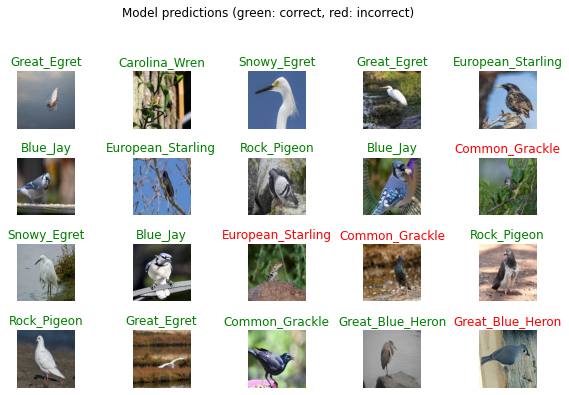

In [18]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
tf.saved_model.save(model, "path/to/saved_model")